In [1]:
%load_ext autoreload
%autoreload 2
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
from LSTM import Mase, LSTM, Preprocess
from torch.utils.data import DataLoader     
import matplotlib.pyplot as plt
import warnings
from torch.nn.utils import clip_grad_norm_
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [2]:
tickers = ['CHPT','EVGO', 'INDI', 'LAZR', 'LCID','LI', 'NIO', 'RIVN', 'TSLA', 'XPEV',  ]
train_raw = yf.download(tickers, start='2024-01-01', end='2024-08-31')['Close']
train_raw_pct = train_raw.pct_change().iloc[1:]
test = yf.download(tickers, start='2024-08-30', end='2024-09-30')['Close']
test_pct = test.pct_change().iloc[1:]
train_test_raw = pd.concat([train_raw, test])
test_length = len(test) - 1
train_raw.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Ticker,CHPT,EVGO,INDI,LAZR,LCID,LI,NIO,RIVN,TSLA,XPEV
Date,,,,,,,,,,
2024-01-02 00:00:00+00:00,2.17,3.30,7.58,3.12,4.15,34.590000,8.42,21.10,248.419998,14.04
2024-01-03 00:00:00+00:00,2.06,3.14,7.35,2.98,3.96,35.740002,8.50,20.32,238.449997,14.23
2024-01-04 00:00:00+00:00,2.11,3.13,7.07,3.03,3.89,35.110001,8.27,19.50,237.929993,13.79
2024-01-05 00:00:00+00:00,2.23,3.09,7.08,3.27,3.78,34.160000,8.06,19.08,237.490005,13.09
2024-01-08 00:00:00+00:00,2.23,3.19,7.51,3.31,3.80,34.000000,7.93,19.58,240.449997,12.70


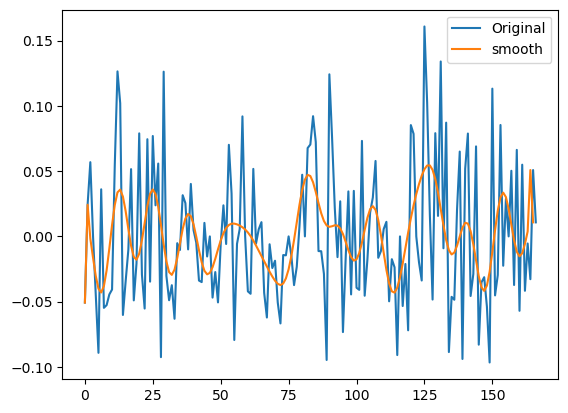

In [3]:
stock = 'CHPT'
offset = 2
rft = np.fft.rfft(train_raw_pct[stock])
rft[15:] = 0
smooth_chpt = np.fft.irfft(rft)
smooth_chpt[:offset],smooth_chpt[-offset:] = train_raw_pct[stock][:offset].to_numpy(), train_raw_pct[stock][-offset:].to_numpy()
plt.plot(np.arange(len(train_raw_pct)), train_raw_pct[stock], label = 'Original')
plt.plot(np.arange(len(train_raw_pct) - 1), smooth_chpt, label = 'smooth')
plt.legend()
plt.show()

In [4]:
time_steps = 20
batch_size = 16
epochs = 300
input_size, output_size, num_layers, hidden_layer = 1, 1, 3, 30,
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mase_results = {}
mape_results = {}
predicted,actual = {}, {}
for stock in tickers:
    print(f"Training on stock: {stock}")
    data = Preprocess(train_raw_pct[stock].to_numpy(), time_steps)

    train = DataLoader(data, batch_size=batch_size,)
    
    model = LSTM(input_size=input_size, output_size=output_size, num_layers=num_layers, hidden_layer=hidden_layer)
    model = model.to(device)
    model.train()
    
    loss_function = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for i in range(epochs):
        for seq, label in train:
            seq, label = seq.to(device), label.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, label)
            single_loss.backward()
            optimizer.step()

        # if i == 499 or i == 999:
        #      print(f'Epoch {i} Loss: {single_loss.item():.8f}')

    model.eval()
    cur = data.forecast_element().view(1, time_steps, -1).to(device)
    test_data = data.scaler.transform(test_pct[stock].to_numpy().reshape(-1, 1))
    predicted_change = []
    
    for x in range(len(test_data)):
        with torch.no_grad():
            cur_pred = model(cur)
        predicted_change.append(data.inv_transform(cur_pred.cpu().numpy()))
        cur_pred = cur_pred.view(1, 1, -1)
        cur = torch.cat((cur[:, 1:, :], torch.Tensor(test_data[x]).view(1, 1, -1).to(device)), dim=1)
        #cur = torch.cat((cur[:, 1:, :], cur_pred.to(device)), dim=1)
    
    predicted_change= np.array(predicted_change).squeeze()
    predicted_price = []
    for x,y in zip(predicted_change, test[stock].to_numpy()[:-1]):
        predicted_price.append((1+x)*y)
    predicted_price = np.array(predicted_price)
    # predicted_price = [test[stock][0]]
    # for x in predicted_change:
    #     predicted_price.append(predicted_price[-1]*(1+x))
    # predicted_price = np.array(predicted_price[1:])
    mase, mape = Mase(train_test_raw[stock], predicted_price, 1, test_length)
    mase_results[stock] = mase
    mape_results[stock] = mape
    predicted[stock] = predicted_price
    actual[stock] = test[stock].to_numpy()[1:]
    del model

for ticker, mase_value in mase_results.items():
    print(f"MASE for {ticker}: {mase_value}")
print(f"Average MASE: {np.mean(list(mase_results.values())):.4f}")

Training on stock: CHPT
Training on stock: EVGO
Training on stock: INDI
Training on stock: LAZR
Training on stock: LCID
Training on stock: LI
Training on stock: NIO
Training on stock: RIVN
Training on stock: TSLA
Training on stock: XPEV
MASE for CHPT: 1.1157444100065215
MASE for EVGO: 1.038201484931079
MASE for INDI: 1.112272774924504
MASE for LAZR: 1.1480918990819786
MASE for LCID: 1.0797467386647654
MASE for LI: 1.0711641171084767
MASE for NIO: 0.9511004606452135
MASE for RIVN: 1.281811174282457
MASE for TSLA: 1.2163396619360822
MASE for XPEV: 0.9241620460401887
Average MASE: 1.0939


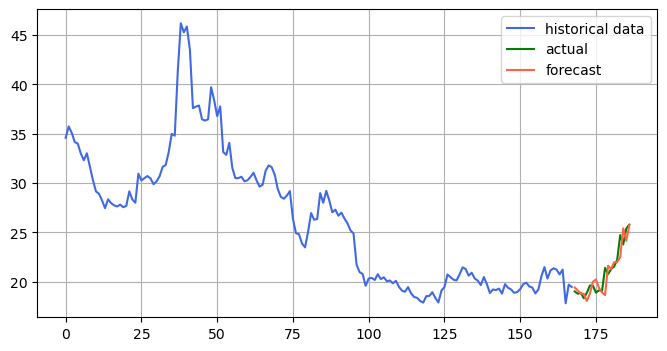

In [5]:
import matplotlib.pyplot as plt
forecast_index = range(len(train_raw), len(train_raw) + len(test) - 1)
index = 'LI'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index], color="royalblue", label="historical data")
#plt.plot(range(1, len(train_raw)), predicted_prices[:,index][:-1], color="royalblue", label="tes data")
plt.plot(forecast_index, actual[index], color="green", label="actual")
plt.plot(forecast_index, predicted[index], color="tomato", label="forecast")
plt.legend()
plt.grid()
plt.show()

In [6]:
mase_results, mape_results

({'CHPT': 1.1157444100065215,
  'EVGO': 1.038201484931079,
  'INDI': 1.112272774924504,
  'LAZR': 1.1480918990819786,
  'LCID': 1.0797467386647654,
  'LI': 1.0711641171084767,
  'NIO': 0.9511004606452135,
  'RIVN': 1.281811174282457,
  'TSLA': 1.2163396619360822,
  'XPEV': 0.9241620460401887},
 {'CHPT': 0.048920778716325254,
  'EVGO': 0.034045387211990887,
  'INDI': 0.049938991705901714,
  'LAZR': 0.06763112711086283,
  'LCID': 0.03193847500162635,
  'LI': 0.035618496108070295,
  'NIO': 0.04754357233442722,
  'RIVN': 0.03987125168626813,
  'TSLA': 0.0327348856489766,
  'XPEV': 0.039532879568258815})

In [7]:
mape_results

{'CHPT': 0.048920778716325254,
 'EVGO': 0.034045387211990887,
 'INDI': 0.049938991705901714,
 'LAZR': 0.06763112711086283,
 'LCID': 0.03193847500162635,
 'LI': 0.035618496108070295,
 'NIO': 0.04754357233442722,
 'RIVN': 0.03987125168626813,
 'TSLA': 0.0327348856489766,
 'XPEV': 0.039532879568258815}

In [8]:
predicted

{'CHPT': array([1.90037317, 1.70185334, 1.64777601, 1.33205302, 1.24321995,
        1.21551455, 1.25296053, 1.34330181, 1.353393  , 1.41402347,
        1.38647261, 1.54462683, 1.46976194, 1.43717711, 1.35481681,
        1.3306242 , 1.40580988, 1.33948068, 1.43782798]),
 'EVGO': array([4.56451823, 4.11035895, 4.08033176, 4.10073456, 3.84378036,
        3.77103183, 4.11263018, 4.41635852, 4.59163074, 4.82933569,
        4.5091966 , 4.74497444, 4.38538212, 4.24794255, 4.09185109,
        3.98001982, 4.13500969, 4.14390173, 4.2246611 ]),
 'INDI': array([4.15789873, 3.7848162 , 3.88826644, 3.809917  , 3.44186679,
        3.07378818, 3.02707184, 3.44354622, 3.69655489, 4.0480863 ,
        3.99104271, 3.8324595 , 3.67044073, 3.76561623, 3.51203619,
        3.47362209, 3.81351064, 3.79785748, 4.19748354]),
 'LAZR': array([0.97625698, 0.9484839 , 0.9496637 , 0.88963216, 0.77149526,
        0.77808248, 0.72922268, 0.74161104, 0.77091281, 0.86032206,
        0.96725078, 0.84809322, 0.766084  , 0.